<a href="https://colab.research.google.com/github/sahil301290/2DFaceRecognition/blob/main/BosPNG_2DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Unzipping the dataset

In [2]:
!unzip '/content/drive/MyDrive/Datasets/3DFaceDatasets/Bosphorus.zip' &> /dev/null

##Import Libraries

In [3]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
#from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import math

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, LearningRateScheduler
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image 
from tensorflow.keras.layers import BatchNormalization
from keras import optimizers
from tensorflow.keras.optimizers import Adam as Adam

#Converting PNG image to size of 112 x 112 x 1

In [4]:
train_image = []
image_label = []

for i in range(105):
    #print('now we are in the folder: bs'+str(format(i, '03d')))
    labels = imread("/content/Bosphorus/bs"+str(format(i, '03d'))+"/*.png")
    for j in range(len(labels)):
        img = labels[j]
        img = color.rgb2gray(img)
        img = img[50:,120:-50]
        img = cv2.resize(img,(112,112))
        label = i
        train_image.append([img,label])
        image_label.append(i)
print('Conversion Completed!')

Conversion Completed!


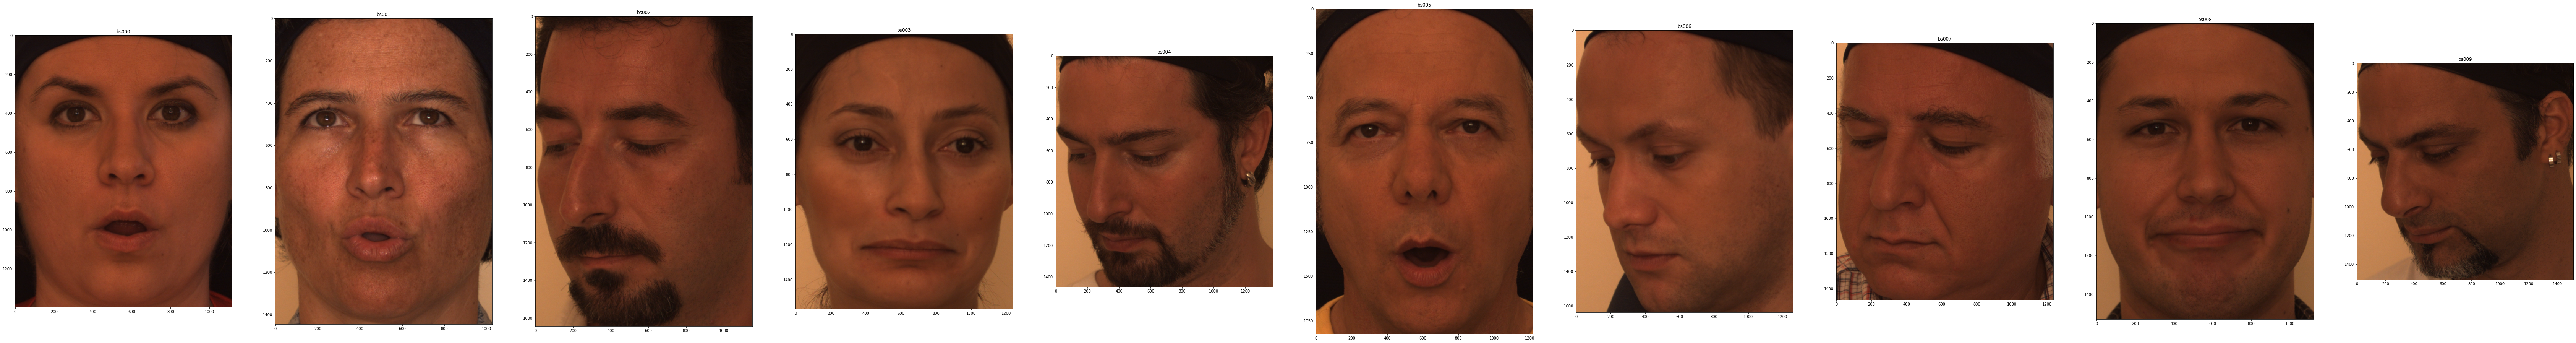

In [5]:
# getting one image per label
f, ax = plt.subplots(1, 10, figsize = (120,120))
for i in range(10):
  labels = imread("/content/Bosphorus/bs"+str(format(i, '03d'))+"/*.png")
  for j in range(1):
      img = labels[j]
      label = i
      ax[i].imshow(img)
      ax[i].set_title('bs'+str(format(i, '03d')))
      plt.show

In [6]:
len(train_image)

4666

## Randomly shuffling the images

In [7]:
import random
random.shuffle(train_image)

## Splitting the image and label to two different lists

In [8]:
X = []
Y = []
for features,labels in train_image:
    X.append(features)
    Y.append(labels)

print (len(X), len(Y))

4666 4666


#Visualizing one image

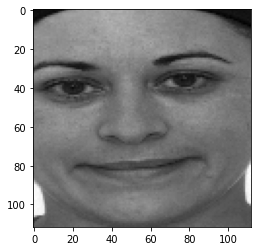

29


In [9]:
plt.imshow(X[5],cmap= 'gray')
plt.show()
print(Y[5])

## Converting images to nparray. Encoding the Y

In [10]:
X = np.array(X).reshape(-1,112,112,1)
Y = to_categorical(Y)
print (X.shape)

(4666, 112, 112, 1)


In [11]:
print(Y[5])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


##Splitting Train and Test

In [12]:
## Designing the Layers
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2)

In [13]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(3732, 112, 112, 1) (934, 112, 112, 1) (3732, 105) (934, 105)


## Designing the Layers

In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, kernel_size=(3,3),activation='relu',input_shape=(112,112,1),padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
  tf.keras.layers.Conv2D(64, kernel_size=(3,3),activation='relu',input_shape=(112,112,1),padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, kernel_size=(3,3),activation='relu',input_shape=(112,112,1),padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
  tf.keras.layers.Conv2D(128, kernel_size=(3,3),activation='relu',input_shape=(112,112,1),padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(105, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 64)       256       
 hNormalization)                                                 
                                                        

##Hyperparameter tuning of optimizer and model compilation

In [15]:
adam = tf.keras.optimizers.Adam(
            learning_rate=0.0005, 
            beta_1=0.9, 
            beta_2=0.999, 
            epsilon=1e-07,
            name='Adam'
)
def step_decay(epoch):
    initial_lrate = 0.0005
    drop = 0.9
    epochs_drop = 1
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
checkpoint = ModelCheckpoint(
                'model.h5',
                monitor='val_acc',
                verbose=0,
                save_best_only=True,
                mode='max'
                )

lrate = LearningRateScheduler(step_decay)

## Model Training

In [16]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 25, validation_data=(X_test, y_test), callbacks=[checkpoint, lrate])

Epoch 1/25
117/117 [==============================] - 18s 69ms/step - loss: 4.7459 - accuracy: 0.0343 - val_loss: 4.9290 - val_accuracy: 0.0096 - lr: 4.5000e-04
Epoch 2/25
117/117 [==============================] - 7s 62ms/step - loss: 4.0691 - accuracy: 0.0930 - val_loss: 6.0986 - val_accuracy: 0.0161 - lr: 4.0500e-04
Epoch 3/25
117/117 [==============================] - 7s 61ms/step - loss: 3.4173 - accuracy: 0.1991 - val_loss: 6.7610 - val_accuracy: 0.0225 - lr: 3.6450e-04
Epoch 4/25
117/117 [==============================] - 7s 60ms/step - loss: 2.9040 - accuracy: 0.2926 - val_loss: 4.4147 - val_accuracy: 0.0760 - lr: 3.2805e-04
Epoch 5/25
117/117 [==============================] - 7s 61ms/step - loss: 2.4482 - accuracy: 0.3840 - val_loss: 2.6339 - val_accuracy: 0.4047 - lr: 2.9525e-04
Epoch 6/25
117/117 [==============================] - 7s 60ms/step - loss: 2.1864 - accuracy: 0.4335 - val_loss: 1.6636 - val_accuracy: 0.6178 - lr: 2.6572e-04
Epoch 7/25
117/117 [===================

##Saving the model

In [17]:
model.save('my_2D_h5_model.h5')

##Plot the training and validation accuracy and loss at each epoch

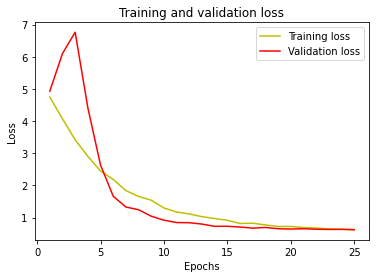

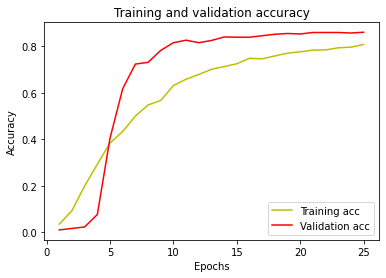

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##Getting the predictions

In [19]:
predictions = model.predict(X_test)
predictions

array([[1.00410695e-11, 8.35763387e-07, 1.00387460e-16, ...,
        5.14118641e-13, 6.66011842e-14, 3.30775233e-16],
       [9.65273870e-08, 9.94838558e-08, 1.00249541e-04, ...,
        4.94790875e-08, 5.03294496e-03, 2.93468195e-03],
       [2.70087636e-13, 1.67594497e-12, 4.29272123e-13, ...,
        1.26436896e-14, 1.63197584e-14, 1.52985649e-15],
       ...,
       [4.06369509e-07, 4.39994474e-05, 7.14905357e-10, ...,
        1.35258604e-08, 7.86897481e-09, 4.41785232e-05],
       [5.44140254e-13, 3.83895832e-11, 1.06691289e-07, ...,
        2.51435537e-13, 3.35719847e-07, 3.49525835e-05],
       [3.35893646e-10, 9.61734789e-11, 1.27772140e-08, ...,
        3.23332859e-13, 1.34888549e-17, 2.38065310e-17]], dtype=float32)

In [20]:
# select the index with the maximum probability
predictions = np.argmax(predictions,axis = 1)

predictions = pd.Series(predictions,name="Label")

In [21]:
predictions.head()

0    43
1    84
2    13
3    10
4    37
Name: Label, dtype: int64

In [22]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [23]:
y_test1 = y_test

In [24]:
#Converting OneHotEncoded Values to Labels
y_test1 = pd.Series(np.argmax(y_test1, axis=1))

##Generating the Confusion Matrix and Classification Report

In [25]:
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
cm = confusion_matrix(y_test1,predictions)
print(np.around(cm/cm.sum(axis=1, keepdims=True)*100,1))

[[ 72.7   0.    0.  ...   0.    0.    0. ]
 [  0.   80.    0.  ...   0.    0.    0. ]
 [  0.    0.   88.9 ...   0.    0.    0. ]
 ...
 [  0.    0.    0.  ...  90.   10.    0. ]
 [  0.    0.    0.  ...   0.   90.    0. ]
 [  0.    0.    0.  ...   0.    0.  100. ]]


In [26]:
print(classification_report(y_test1, predictions))

              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.80      0.80      0.80         5
           2       1.00      0.89      0.94         9
           3       0.82      0.75      0.78        12
           4       0.75      0.90      0.82        10
           5       0.91      1.00      0.95        10
           6       0.70      0.78      0.74         9
           7       0.85      0.79      0.81        14
           8       0.78      0.88      0.82         8
           9       1.00      0.86      0.92        14
          10       1.00      0.80      0.89         5
          11       0.58      1.00      0.74         7
          12       1.00      0.83      0.91        12
          13       1.00      0.88      0.93         8
          14       0.89      1.00      0.94         8
          15       0.67      1.00      0.80        10
          16       1.00      0.80      0.89        10
          17       1.00    